In [1]:
import datetime
import os

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose)
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Greys_r'

In [2]:
# loading the training and test sets from TFRecords
raw_training_dataset = tf.data.TFRecordDataset('data/train_images.tfrecords')
raw_val_dataset      = tf.data.TFRecordDataset('data/val_images.tfrecords')

In [3]:
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}

In [4]:
# helper function to extract an image from the dictionary
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset      = raw_val_dataset.map(_parse_image_function)

In [5]:
print(len(list(parsed_training_dataset)))
print(len(list(parsed_val_dataset)))

234
26


In [6]:
# function to read and decode an example from the parsed dataset
@tf.function
def read_and_decode(example):
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    image_raw.set_shape([65536])
    image = tf.reshape(image_raw, [256, 256, 1])

    image = tf.cast(image, tf.float32) * (1. / 1024)

    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    label_raw.set_shape([65536])
    label = tf.reshape(label_raw, [256, 256, 1])

    return image, label

In [7]:
# get datasets read and decoded, and into a state usable by TensorFlow
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(
    read_and_decode, num_parallel_calls=tf_autotune)
val = parsed_val_dataset.map(read_and_decode)
train.element_spec

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [8]:
# setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1

In [9]:
# setup the train and test data by shuffling, prefetching, etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>

In [10]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

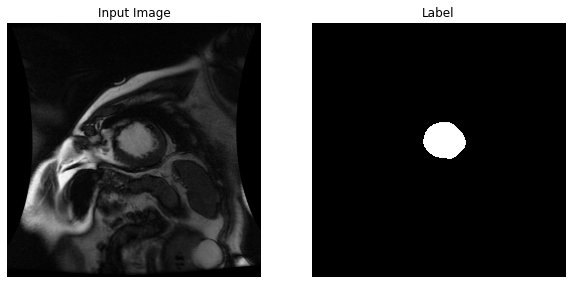

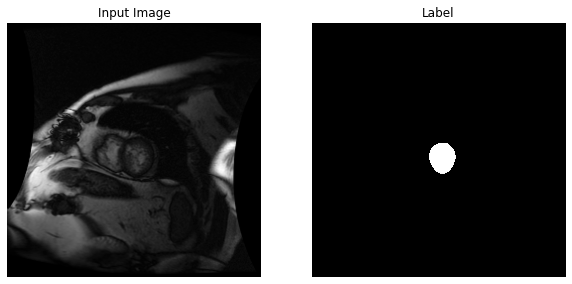

In [11]:
# display an image and label from the training set
for image, label in train.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

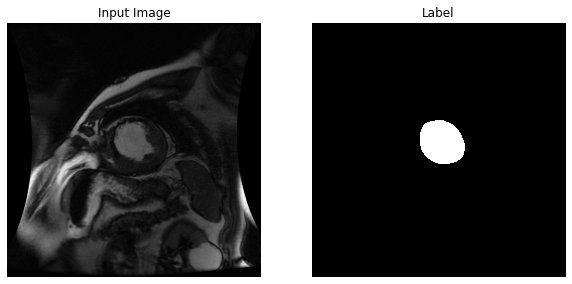

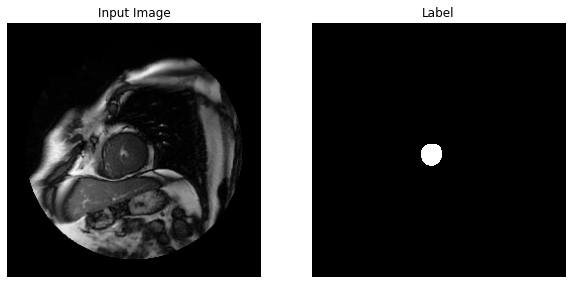

In [13]:
# display an image and label from the test set
for image, label in val.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

In [14]:
tf.keras.backend.clear_session()

# set up the model architecture
model = tf.keras.models.Sequential([
    Flatten(input_shape=[256, 256, 1]),
    Dense(64, activation='relu'),
    Dense(256*256*2, activation='softmax'),
    Reshape((256, 256, 2))
])

# specify how to train the model with algorithm, the loss function and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [15]:
# print out the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4194368   
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            8519680   
_________________________________________________________________
reshape (Reshape)            (None, 256, 256, 2)       0         
Total params: 12,714,048
Trainable params: 12,714,048
Non-trainable params: 0
_________________________________________________________________


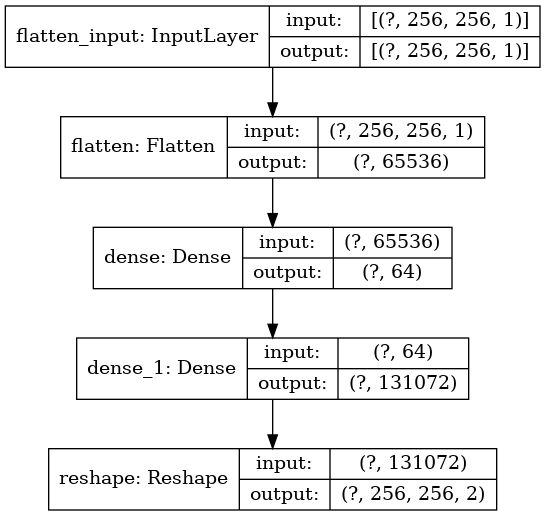

In [16]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
# function to take a prediction from the model and output an image for display
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [18]:
# helper function to show the image, the label and the prediction
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], label[0], create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, sample_label, prediction])

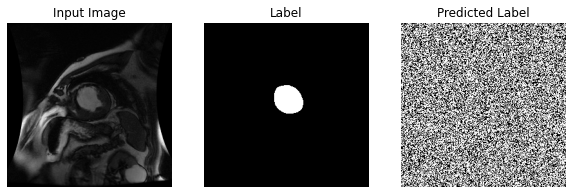

In [19]:
# show a predection, as an example
show_predictions(test_dataset)

In [20]:
# define a callback that shows image predictions on the test set
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# setup a tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Train for 234 steps, validate for 26 steps
Epoch 1/20
229/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5050

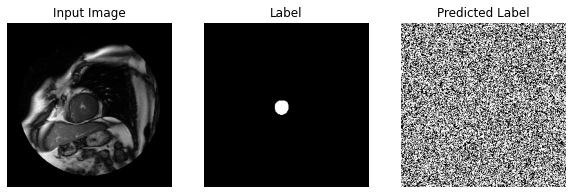


Sample Prediction after epoch 1

234/234 [==============================] - 3s 12ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6931 - val_accuracy: 0.5115
Epoch 2/20
231/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5210

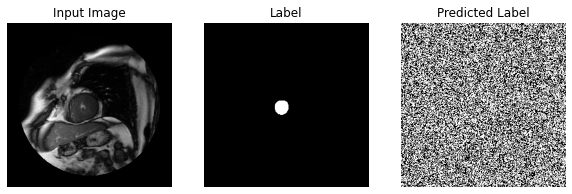


Sample Prediction after epoch 2

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.5212 - val_loss: 0.6931 - val_accuracy: 0.5308
Epoch 3/20
233/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5437

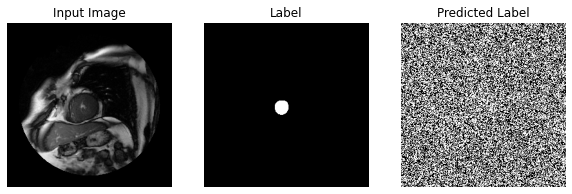


Sample Prediction after epoch 3

234/234 [==============================] - 2s 10ms/step - loss: 0.6931 - accuracy: 0.5438 - val_loss: 0.6931 - val_accuracy: 0.5597
Epoch 4/20
229/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5866

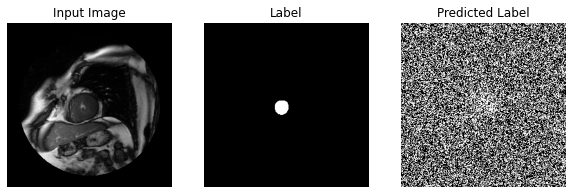


Sample Prediction after epoch 4

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.5874 - val_loss: 0.6931 - val_accuracy: 0.6259
Epoch 5/20
225/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.6900

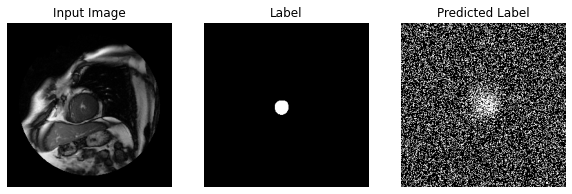


Sample Prediction after epoch 5

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.6934 - val_loss: 0.6931 - val_accuracy: 0.7809
Epoch 6/20
225/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.8799

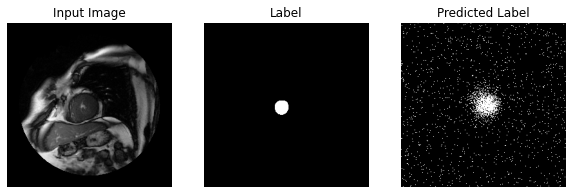


Sample Prediction after epoch 6

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.8832 - val_loss: 0.6931 - val_accuracy: 0.9670
Epoch 7/20
227/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9824

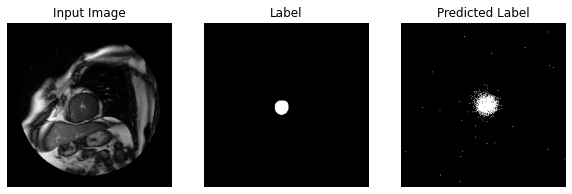


Sample Prediction after epoch 7

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9824 - val_loss: 0.6931 - val_accuracy: 0.9862
Epoch 8/20
223/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.9861

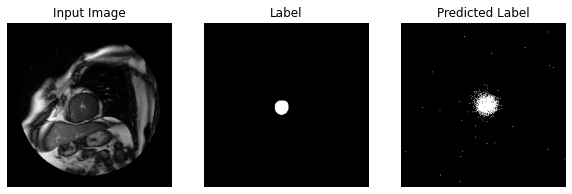


Sample Prediction after epoch 8

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9862 - val_loss: 0.6931 - val_accuracy: 0.9862
Epoch 9/20
228/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9863

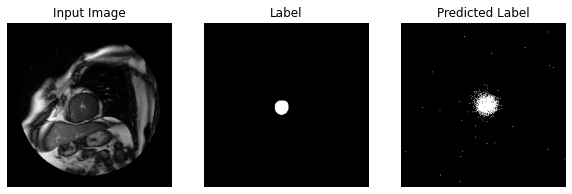


Sample Prediction after epoch 9

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9862 - val_loss: 0.6931 - val_accuracy: 0.9862
Epoch 10/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9862

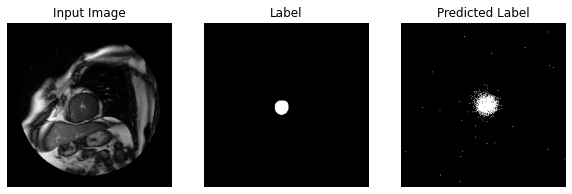


Sample Prediction after epoch 10

234/234 [==============================] - 2s 10ms/step - loss: 0.6931 - accuracy: 0.9862 - val_loss: 0.6931 - val_accuracy: 0.9862
Epoch 11/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9863

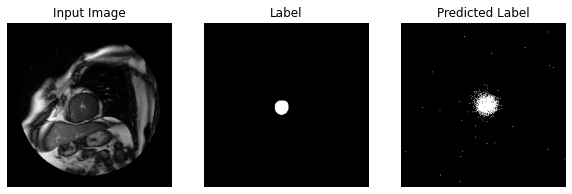


Sample Prediction after epoch 11

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9862 - val_loss: 0.6931 - val_accuracy: 0.9862
Epoch 12/20
231/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9863

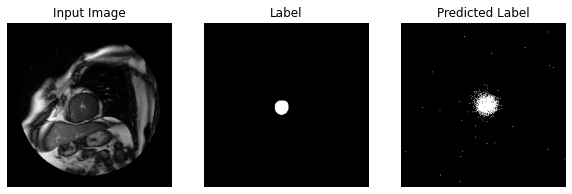


Sample Prediction after epoch 12

234/234 [==============================] - 2s 10ms/step - loss: 0.6931 - accuracy: 0.9862 - val_loss: 0.6931 - val_accuracy: 0.9862
Epoch 13/20
223/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.9862

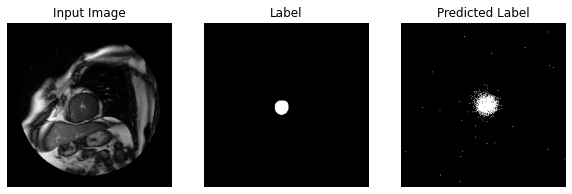


Sample Prediction after epoch 13

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9862 - val_loss: 0.6931 - val_accuracy: 0.9862
Epoch 14/20
224/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.9861

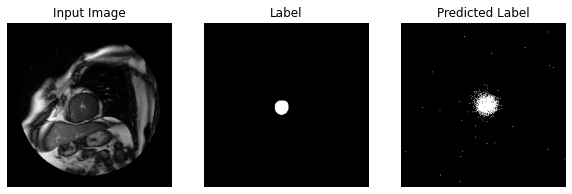


Sample Prediction after epoch 14

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9862 - val_loss: 0.6931 - val_accuracy: 0.9862
Epoch 15/20
233/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9862

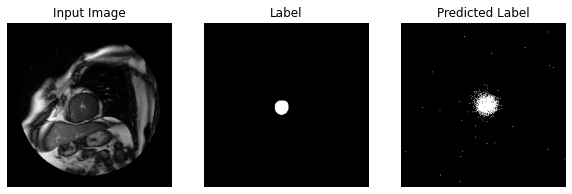


Sample Prediction after epoch 15

234/234 [==============================] - 2s 10ms/step - loss: 0.6931 - accuracy: 0.9862 - val_loss: 0.6931 - val_accuracy: 0.9862
Epoch 16/20
231/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9862

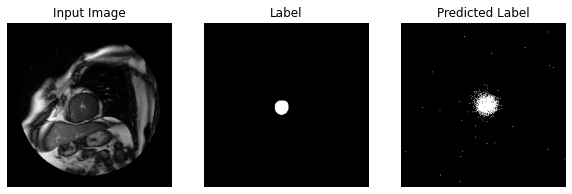


Sample Prediction after epoch 16

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9862 - val_loss: 0.6931 - val_accuracy: 0.9862
Epoch 17/20
229/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9861

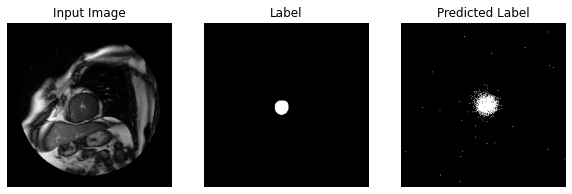


Sample Prediction after epoch 17

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9862 - val_loss: 0.6931 - val_accuracy: 0.9862
Epoch 18/20
227/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9863

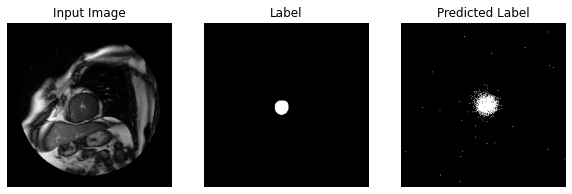


Sample Prediction after epoch 18

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9862 - val_loss: 0.6931 - val_accuracy: 0.9862
Epoch 19/20
230/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9863

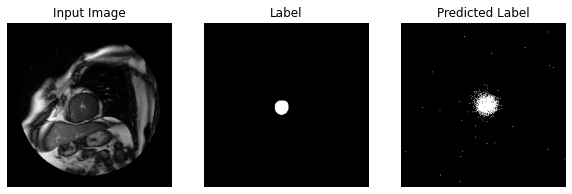


Sample Prediction after epoch 19

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9862 - val_loss: 0.6931 - val_accuracy: 0.9862
Epoch 20/20
224/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.9861

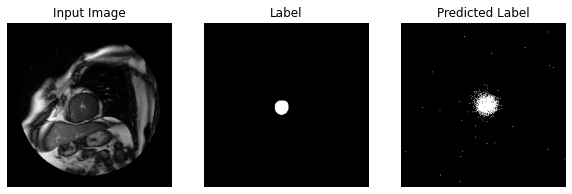


Sample Prediction after epoch 20

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9862 - val_loss: 0.6931 - val_accuracy: 0.9862


In [21]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

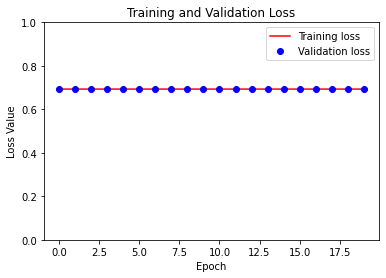

In [22]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [23]:
model.evaluate(test_dataset)

     26/Unknown - 0s 4ms/step - loss: 0.6931 - accuracy: 0.9862

[0.6931414008140564, 0.98622364]

In [24]:
%load_ext tensorboard

In [25]:
%tensorboard --logdir logs

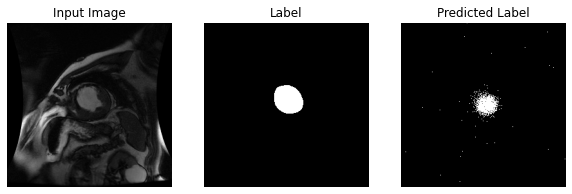

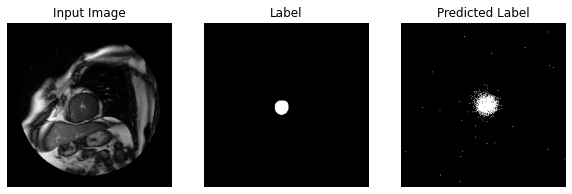

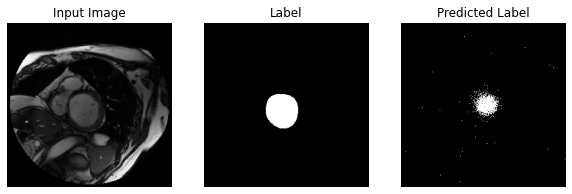

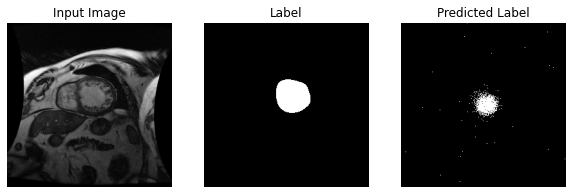

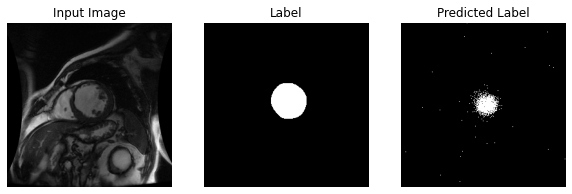

In [26]:
show_predictions(test_dataset, 5)

In [27]:
tf.keras.backend.clear_session()

layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=2,
           kernel_size=1,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
]

model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [28]:
# print out the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 128, 128, 100)     2600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 100)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 200)       500200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 300)       540300    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 300)       810300    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 2)         6

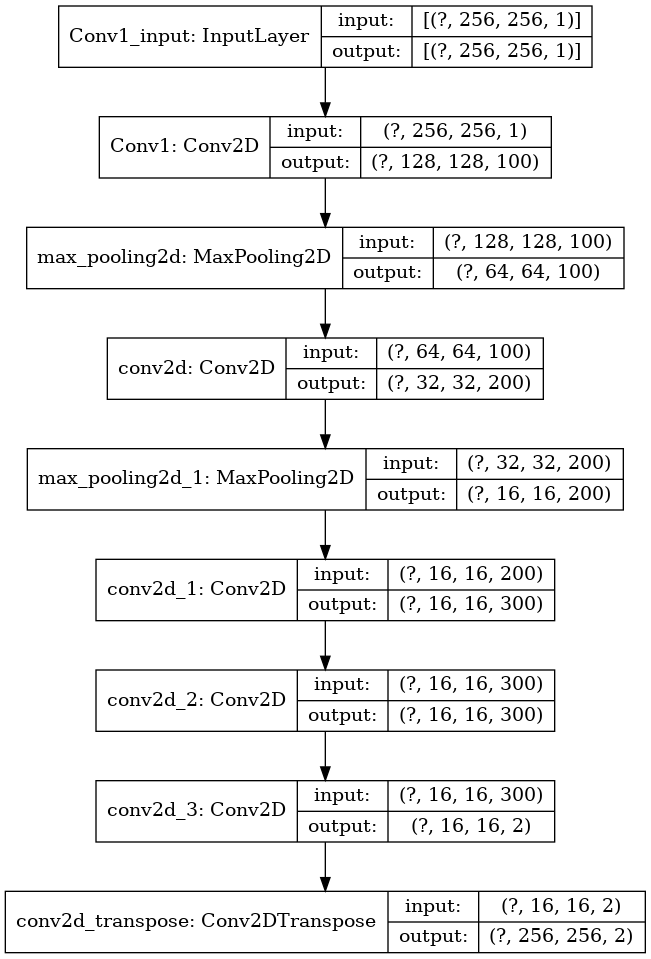

In [29]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

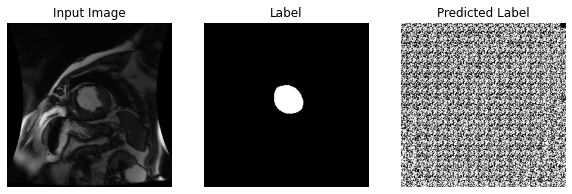

In [30]:
# show a predection, as an example
show_predictions(test_dataset)

In [31]:
# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Train for 234 steps, validate for 26 steps
Epoch 1/20
228/234 [============================>.] - ETA: 0s - loss: 0.5950 - accuracy: 0.9816

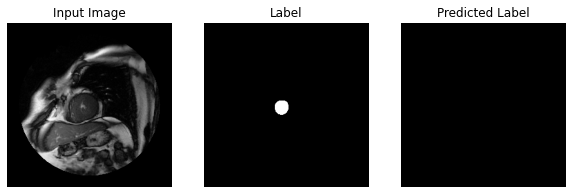


Sample Prediction after epoch 1

234/234 [==============================] - 3s 14ms/step - loss: 0.5928 - accuracy: 0.9815 - val_loss: 0.5037 - val_accuracy: 0.9830
Epoch 2/20
231/234 [============================>.] - ETA: 0s - loss: 0.4361 - accuracy: 0.9837

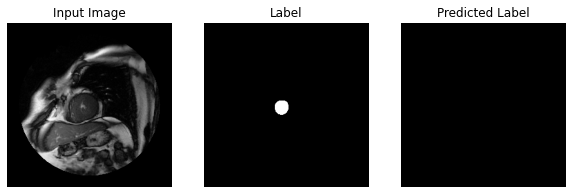


Sample Prediction after epoch 2

234/234 [==============================] - 2s 7ms/step - loss: 0.4354 - accuracy: 0.9836 - val_loss: 0.3759 - val_accuracy: 0.9830
Epoch 3/20
231/234 [============================>.] - ETA: 0s - loss: 0.3304 - accuracy: 0.9836

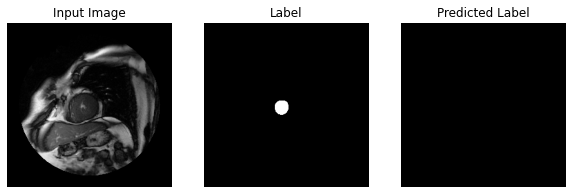


Sample Prediction after epoch 3

234/234 [==============================] - 2s 7ms/step - loss: 0.3299 - accuracy: 0.9836 - val_loss: 0.2905 - val_accuracy: 0.9830
Epoch 4/20
231/234 [============================>.] - ETA: 0s - loss: 0.2596 - accuracy: 0.9835

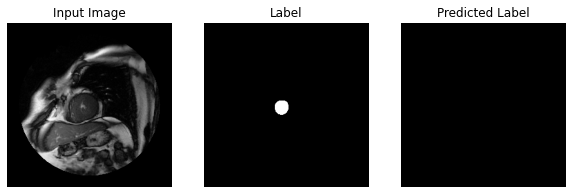


Sample Prediction after epoch 4

234/234 [==============================] - 2s 7ms/step - loss: 0.2591 - accuracy: 0.9836 - val_loss: 0.2328 - val_accuracy: 0.9830
Epoch 5/20
226/234 [===========================>..] - ETA: 0s - loss: 0.2113 - accuracy: 0.9836

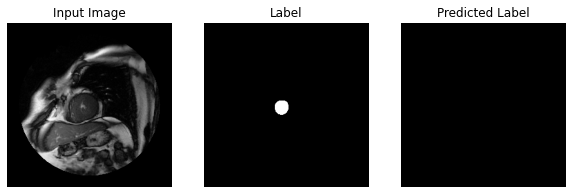


Sample Prediction after epoch 5

234/234 [==============================] - 2s 7ms/step - loss: 0.2107 - accuracy: 0.9836 - val_loss: 0.1930 - val_accuracy: 0.9830
Epoch 6/20
230/234 [============================>.] - ETA: 0s - loss: 0.1772 - accuracy: 0.9836

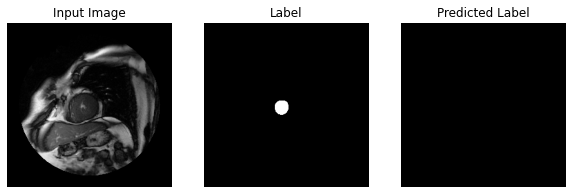


Sample Prediction after epoch 6

234/234 [==============================] - 2s 7ms/step - loss: 0.1770 - accuracy: 0.9836 - val_loss: 0.1650 - val_accuracy: 0.9830
Epoch 7/20
230/234 [============================>.] - ETA: 0s - loss: 0.1534 - accuracy: 0.9835

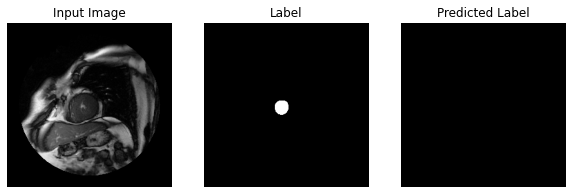


Sample Prediction after epoch 7

234/234 [==============================] - 2s 7ms/step - loss: 0.1531 - accuracy: 0.9836 - val_loss: 0.1448 - val_accuracy: 0.9830
Epoch 8/20
231/234 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.9837

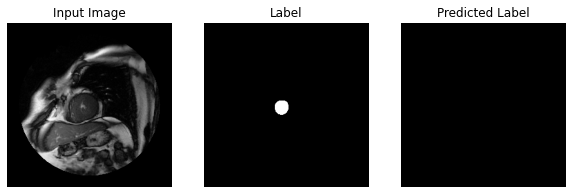


Sample Prediction after epoch 8

234/234 [==============================] - 2s 7ms/step - loss: 0.1357 - accuracy: 0.9836 - val_loss: 0.1301 - val_accuracy: 0.9830
Epoch 9/20
229/234 [============================>.] - ETA: 0s - loss: 0.1227 - accuracy: 0.9837

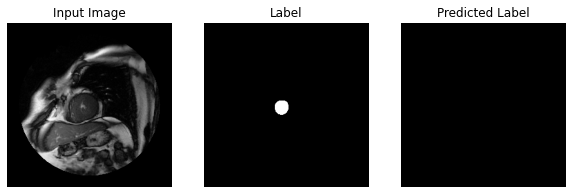


Sample Prediction after epoch 9

234/234 [==============================] - 2s 7ms/step - loss: 0.1228 - accuracy: 0.9836 - val_loss: 0.1192 - val_accuracy: 0.9830
Epoch 10/20
230/234 [============================>.] - ETA: 0s - loss: 0.1133 - accuracy: 0.9836

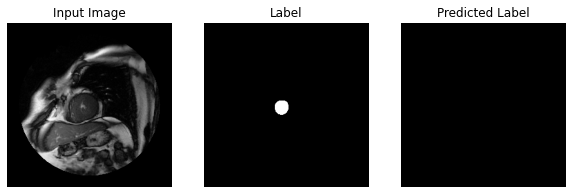


Sample Prediction after epoch 10

234/234 [==============================] - 2s 7ms/step - loss: 0.1133 - accuracy: 0.9836 - val_loss: 0.1110 - val_accuracy: 0.9830
Epoch 11/20
231/234 [============================>.] - ETA: 0s - loss: 0.1057 - accuracy: 0.9837

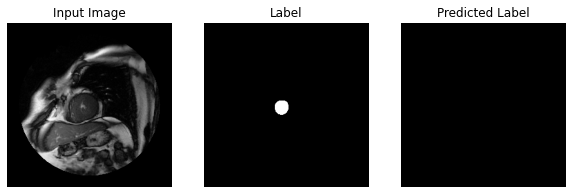


Sample Prediction after epoch 11

234/234 [==============================] - 2s 7ms/step - loss: 0.1060 - accuracy: 0.9836 - val_loss: 0.1049 - val_accuracy: 0.9830
Epoch 12/20
231/234 [============================>.] - ETA: 0s - loss: 0.1001 - accuracy: 0.9838

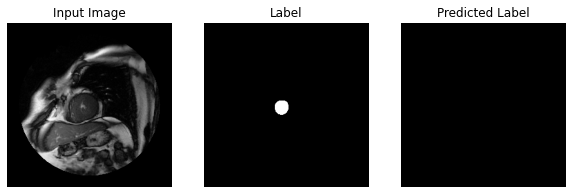


Sample Prediction after epoch 12

234/234 [==============================] - 2s 7ms/step - loss: 0.1005 - accuracy: 0.9836 - val_loss: 0.1001 - val_accuracy: 0.9830
Epoch 13/20
231/234 [============================>.] - ETA: 0s - loss: 0.0960 - accuracy: 0.9837

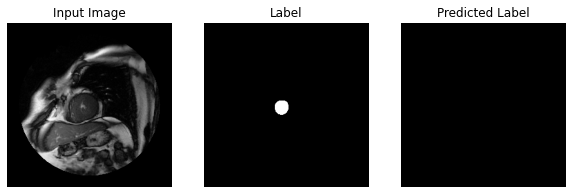


Sample Prediction after epoch 13

234/234 [==============================] - 2s 7ms/step - loss: 0.0963 - accuracy: 0.9836 - val_loss: 0.0966 - val_accuracy: 0.9830
Epoch 14/20
228/234 [============================>.] - ETA: 0s - loss: 0.0930 - accuracy: 0.9836

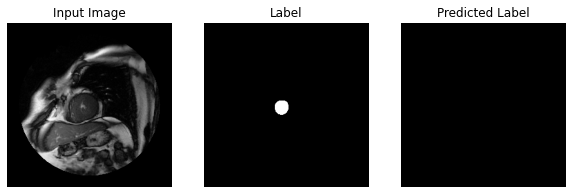


Sample Prediction after epoch 14

234/234 [==============================] - 2s 7ms/step - loss: 0.0931 - accuracy: 0.9836 - val_loss: 0.0938 - val_accuracy: 0.9830
Epoch 15/20
230/234 [============================>.] - ETA: 0s - loss: 0.0912 - accuracy: 0.9834

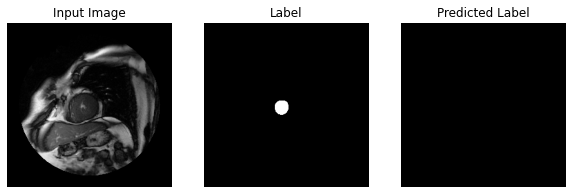


Sample Prediction after epoch 15

234/234 [==============================] - 2s 7ms/step - loss: 0.0906 - accuracy: 0.9836 - val_loss: 0.0918 - val_accuracy: 0.9830
Epoch 16/20
230/234 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9835

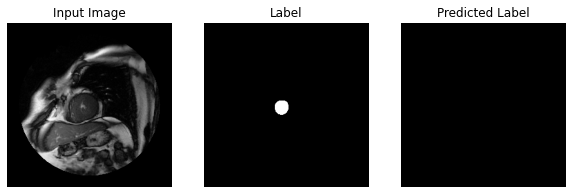


Sample Prediction after epoch 16

234/234 [==============================] - 2s 7ms/step - loss: 0.0888 - accuracy: 0.9836 - val_loss: 0.0902 - val_accuracy: 0.9830
Epoch 17/20
230/234 [============================>.] - ETA: 0s - loss: 0.0876 - accuracy: 0.9835

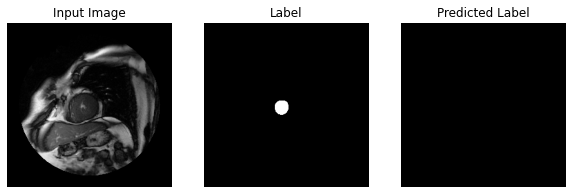


Sample Prediction after epoch 17

234/234 [==============================] - 2s 7ms/step - loss: 0.0873 - accuracy: 0.9836 - val_loss: 0.0890 - val_accuracy: 0.9830
Epoch 18/20
231/234 [============================>.] - ETA: 0s - loss: 0.0860 - accuracy: 0.9837

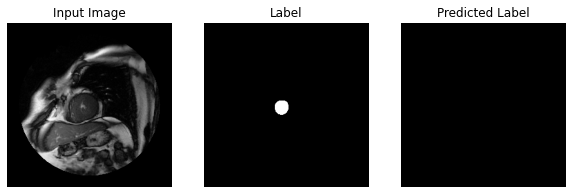


Sample Prediction after epoch 18

234/234 [==============================] - 2s 7ms/step - loss: 0.0863 - accuracy: 0.9836 - val_loss: 0.0882 - val_accuracy: 0.9830
Epoch 19/20
231/234 [============================>.] - ETA: 0s - loss: 0.0853 - accuracy: 0.9837

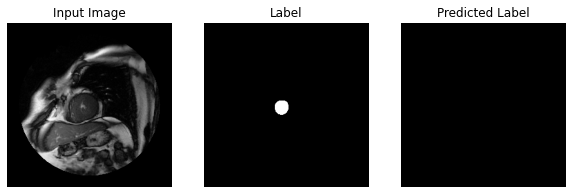


Sample Prediction after epoch 19

234/234 [==============================] - 2s 7ms/step - loss: 0.0855 - accuracy: 0.9836 - val_loss: 0.0875 - val_accuracy: 0.9830
Epoch 20/20
231/234 [============================>.] - ETA: 0s - loss: 0.0851 - accuracy: 0.9836

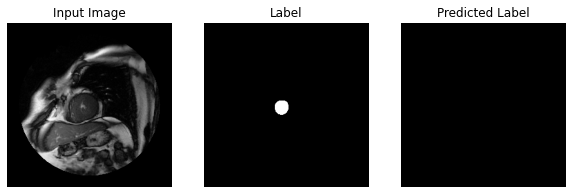


Sample Prediction after epoch 20

234/234 [==============================] - 2s 7ms/step - loss: 0.0849 - accuracy: 0.9836 - val_loss: 0.0871 - val_accuracy: 0.9830


In [32]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

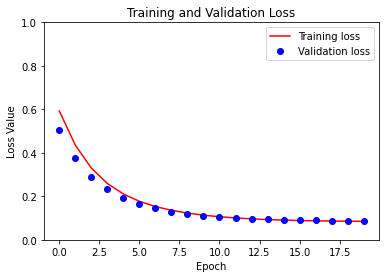

In [33]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [34]:
model.evaluate(test_dataset)

     26/Unknown - 0s 4ms/step - loss: 0.0871 - accuracy: 0.9830

[0.0871012955904007, 0.9829577]

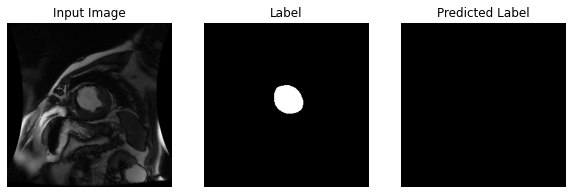

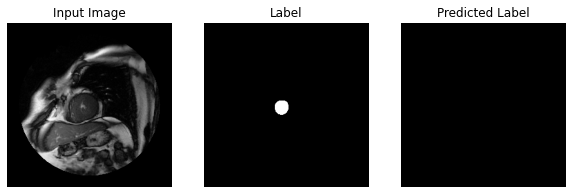

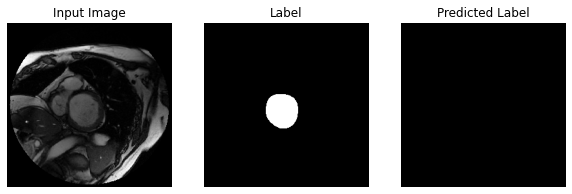

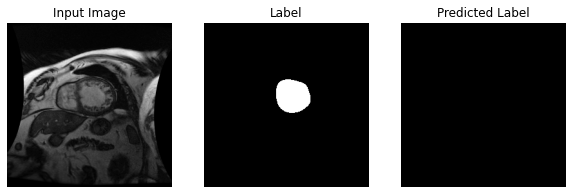

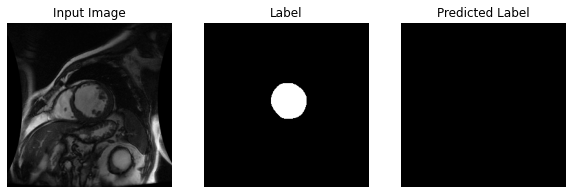

In [35]:
# show predictions from the test data set that has NOT been used for training.
show_predictions(test_dataset, 5)

In [36]:
def dice_coef(y_true, y_pred, smooth=1):
    indices = K.argmax(y_pred, 3)
    indices = K.reshape(indices, [-1, 256, 256, 1])

    true_cast = y_true
    indices_cast = K.cast(indices, dtype='float32')

    axis = [1, 2, 3]
    intersection = K.sum(true_cast * indices_cast, axis=axis)
    union = K.sum(true_cast, axis=axis) + K.sum(indices_cast, axis=axis)
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)

    return dice

In [37]:
# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [38]:
tf.keras.backend.clear_session() 
model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[dice_coef,'accuracy'])

Train for 234 steps
Epoch 1/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0843 - dice_coef: 0.0021 - accuracy: 0.9836

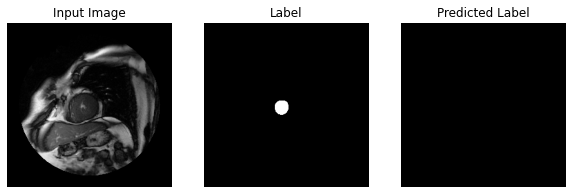


Sample Prediction after epoch 1

234/234 [==============================] - 2s 9ms/step - loss: 0.0842 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0864 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 2/30
228/234 [============================>.] - ETA: 0s - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9837

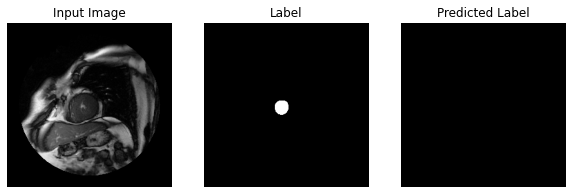


Sample Prediction after epoch 2

234/234 [==============================] - 1s 6ms/step - loss: 0.0838 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 3/30
228/234 [============================>.] - ETA: 0s - loss: 0.0835 - dice_coef: 0.0021 - accuracy: 0.9836

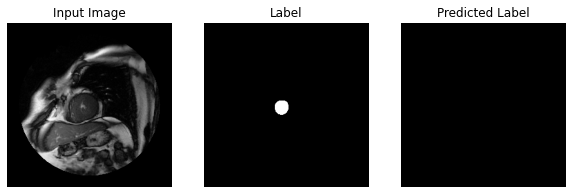


Sample Prediction after epoch 3

234/234 [==============================] - 1s 6ms/step - loss: 0.0837 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 4/30
224/234 [===========================>..] - ETA: 0s - loss: 0.0837 - dice_coef: 0.0021 - accuracy: 0.9836

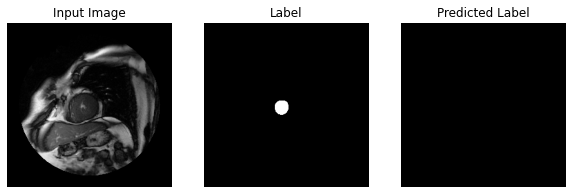


Sample Prediction after epoch 4

234/234 [==============================] - 1s 6ms/step - loss: 0.0837 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 5/30
227/234 [============================>.] - ETA: 0s - loss: 0.0846 - dice_coef: 0.0020 - accuracy: 0.9834

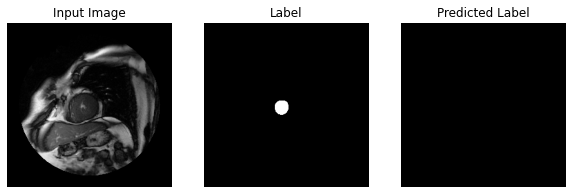


Sample Prediction after epoch 5

234/234 [==============================] - 1s 6ms/step - loss: 0.0837 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 6/30
231/234 [============================>.] - ETA: 0s - loss: 0.0843 - dice_coef: 0.0020 - accuracy: 0.9835

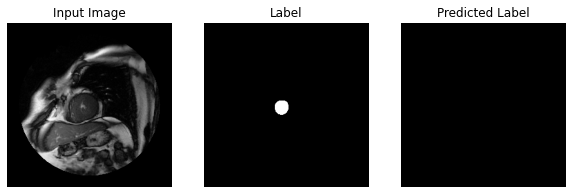


Sample Prediction after epoch 6

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 7/30
227/234 [============================>.] - ETA: 0s - loss: 0.0837 - dice_coef: 0.0021 - accuracy: 0.9836

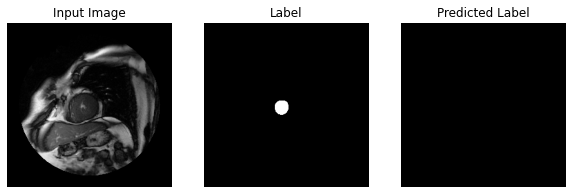


Sample Prediction after epoch 7

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 8/30
229/234 [============================>.] - ETA: 0s - loss: 0.0839 - dice_coef: 0.0021 - accuracy: 0.9835

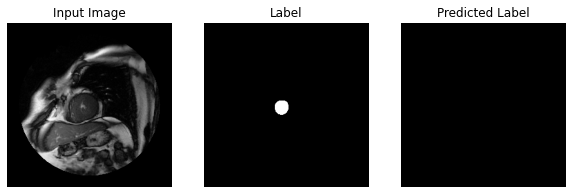


Sample Prediction after epoch 8

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 9/30
228/234 [============================>.] - ETA: 0s - loss: 0.0840 - dice_coef: 0.0021 - accuracy: 0.9835

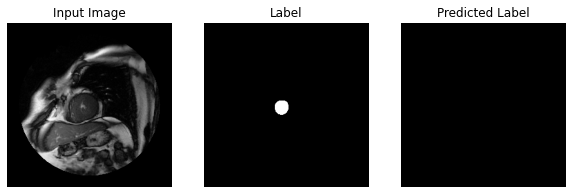


Sample Prediction after epoch 9

234/234 [==============================] - 1s 6ms/step - loss: 0.0837 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 10/30
227/234 [============================>.] - ETA: 0s - loss: 0.0834 - dice_coef: 0.0021 - accuracy: 0.9837

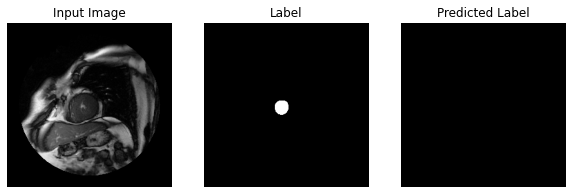


Sample Prediction after epoch 10

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 11/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0842 - dice_coef: 0.0021 - accuracy: 0.9835

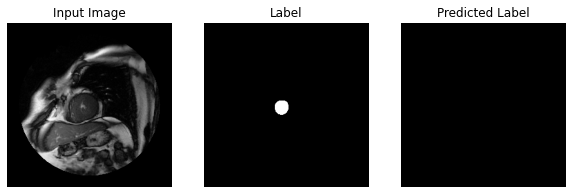


Sample Prediction after epoch 11

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 12/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0834 - dice_coef: 0.0021 - accuracy: 0.9837

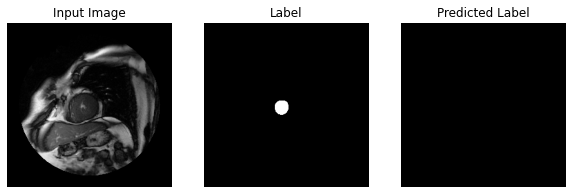


Sample Prediction after epoch 12

234/234 [==============================] - 1s 6ms/step - loss: 0.0837 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 13/30
231/234 [============================>.] - ETA: 0s - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836

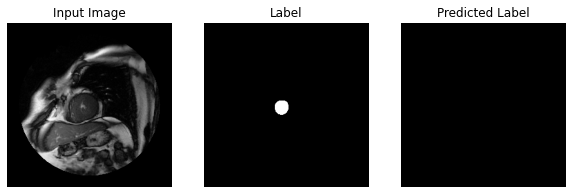


Sample Prediction after epoch 13

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 14/30
230/234 [============================>.] - ETA: 0s - loss: 0.0837 - dice_coef: 0.0021 - accuracy: 0.9836

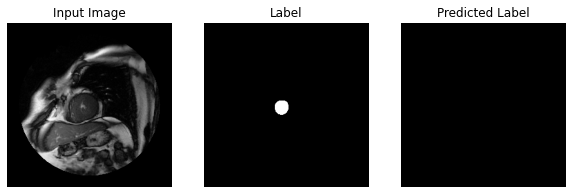


Sample Prediction after epoch 14

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 15/30
231/234 [============================>.] - ETA: 0s - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836

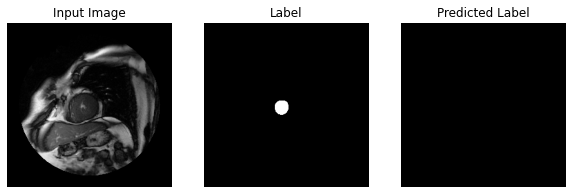


Sample Prediction after epoch 15

234/234 [==============================] - 1s 6ms/step - loss: 0.0837 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 16/30
230/234 [============================>.] - ETA: 0s - loss: 0.0841 - dice_coef: 0.0020 - accuracy: 0.9835

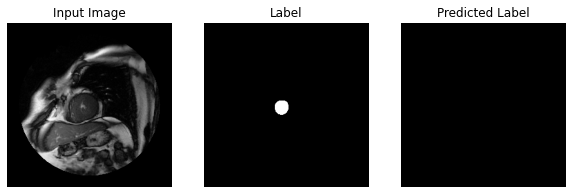


Sample Prediction after epoch 16

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 17/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0828 - dice_coef: 0.0021 - accuracy: 0.9838

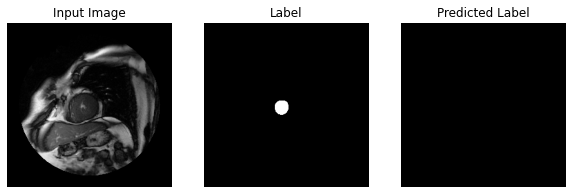


Sample Prediction after epoch 17

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 18/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0837 - dice_coef: 0.0021 - accuracy: 0.9836

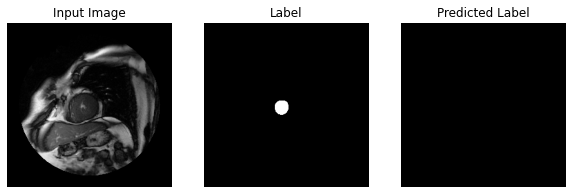


Sample Prediction after epoch 18

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 19/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0840 - dice_coef: 0.0021 - accuracy: 0.9835

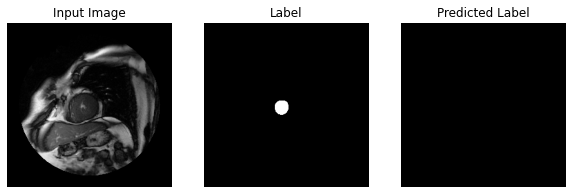


Sample Prediction after epoch 19

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 20/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0834 - dice_coef: 0.0021 - accuracy: 0.9837

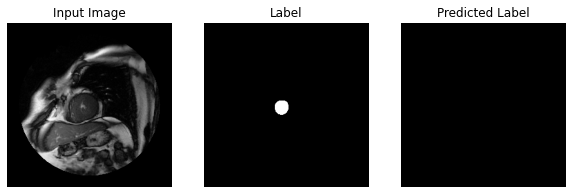


Sample Prediction after epoch 20

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 21/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0835 - dice_coef: 0.0021 - accuracy: 0.9836

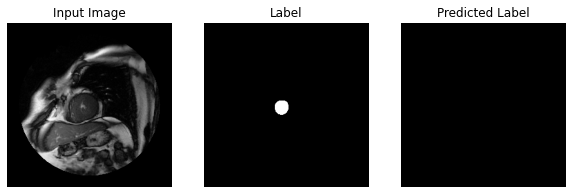


Sample Prediction after epoch 21

234/234 [==============================] - 1s 6ms/step - loss: 0.0837 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 22/30
228/234 [============================>.] - ETA: 0s - loss: 0.0840 - dice_coef: 0.0020 - accuracy: 0.9835

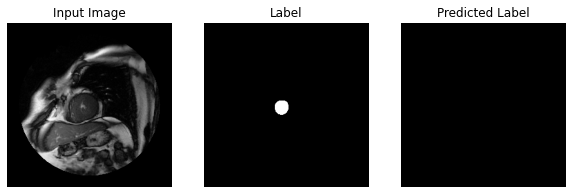


Sample Prediction after epoch 22

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 23/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0838 - dice_coef: 0.0021 - accuracy: 0.9836

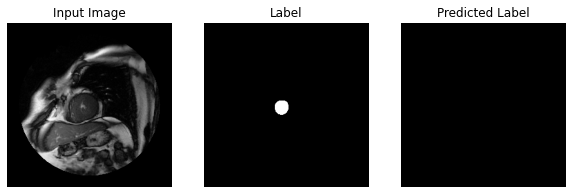


Sample Prediction after epoch 23

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 24/30
224/234 [===========================>..] - ETA: 0s - loss: 0.0837 - dice_coef: 0.0021 - accuracy: 0.9836

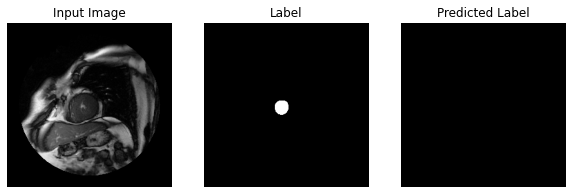


Sample Prediction after epoch 24

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 25/30
228/234 [============================>.] - ETA: 0s - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836

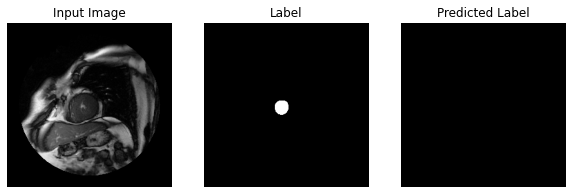


Sample Prediction after epoch 25

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 26/30
232/234 [============================>.] - ETA: 0s - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836

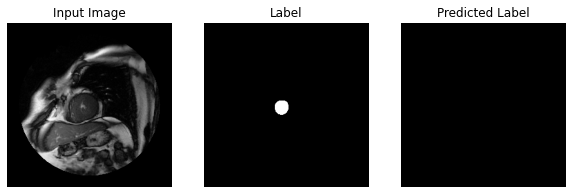


Sample Prediction after epoch 26

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 27/30
227/234 [============================>.] - ETA: 0s - loss: 0.0833 - dice_coef: 0.0021 - accuracy: 0.9837

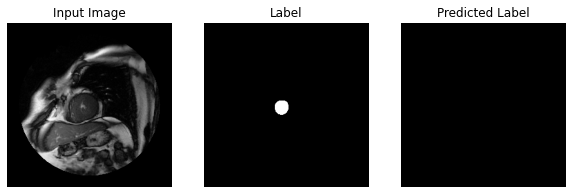


Sample Prediction after epoch 27

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 28/30
230/234 [============================>.] - ETA: 0s - loss: 0.0839 - dice_coef: 0.0021 - accuracy: 0.9836

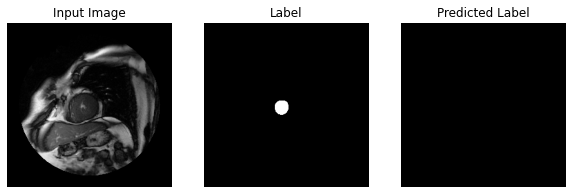


Sample Prediction after epoch 28

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 29/30
229/234 [============================>.] - ETA: 0s - loss: 0.0845 - dice_coef: 0.0020 - accuracy: 0.9834

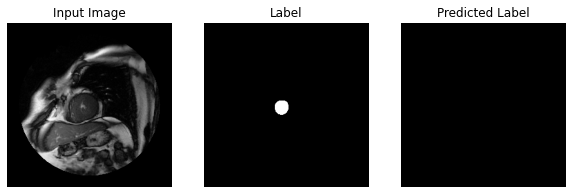


Sample Prediction after epoch 29

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 30/30
224/234 [===========================>..] - ETA: 0s - loss: 0.0829 - dice_coef: 0.0021 - accuracy: 0.9838

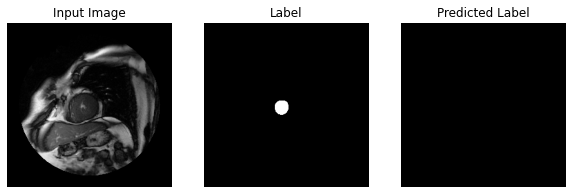


Sample Prediction after epoch 30

234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830


In [39]:
 # setup and run the model
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_training_dataset))

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

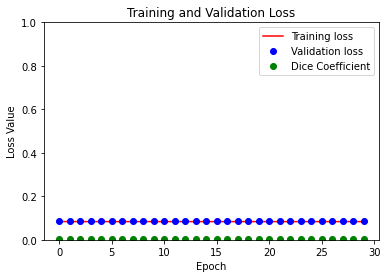

In [40]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [41]:
layers = layers  # Using the same as above. Try to beat us!

# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

tf.keras.backend.clear_session()
model = tf.keras.models.Sequential(layers)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[dice_coef, 'accuracy'])